<a href="https://colab.research.google.com/github/pskaranth/Whales_Classifier/blob/main/xgboost_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Data and Task:

**Task**

To classify speicies of whales based on the echo-location clicks emitted  by beaked whales. Classifier takes run of clicks as the input data and outputs the species that is found in the run.

**Data** 

Data was provided by UCSD team for the Data Science course in edx. Used a sample of about 15MB in size that contains about 2000 samples from each species.










In [1]:
# Install Pyspark & Setup Java Environment

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://www-us.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz  
!tar xf  spark-3.0.3-bin-hadoop3.2.tgz  
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop3.2"
import findspark
findspark.init()

In [2]:
# !pip install py4j

     |████████████████████████████████| 204kB 5.0MB/s 


In [6]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Row, SQLContext, DataFrame
from pyspark.sql.types import *

import numpy as np


In [7]:
%cd /content/drive/MyDrive/Kaggle/Whales_classify

/content/drive/MyDrive/Kaggle/Whales_classify


In [4]:
!ls

processed_data_150mb.np  processed_data_15mb.np  xgboost_pyspark.ipynb


In [8]:
data = np.load('whale_data_15mb.np', allow_pickle=True)  

In [9]:
sc = SparkContext.getOrCreate();
sqlContext = SQLContext(sc)

In [10]:
data_rdd = sc.parallelize(data.tolist())

#### Creating custom schema

In [11]:
schema = StructType([
     StructField('time', TimestampType(), True),
     StructField('species', StringType(), True),
     StructField('site', StringType(), True),
     StructField('rec_no', StringType(), True),
     StructField('bout_i', LongType(), True),
     StructField('peak2peak', DoubleType(), True),
     StructField('MSN', BinaryType(), True),
     StructField('MSP', BinaryType(), True),
     StructField('TPWS1', LongType(), True),
     StructField('MD1', LongType(), True),
     StructField('FD1', LongType(), True),
     StructField('TPWS2', LongType(), True),
     StructField('MD2', LongType(), True),
     StructField('FD2', LongType(), True),
     StructField('TPWS3', LongType(), True),
     StructField('MD3', LongType(), True),
     StructField('FD3', LongType(), True)
])

Each click is defined by the following fields

|field name     | Description               | Data Type
|---------------|---------------------------|--------------
|0: time        | time of click             | string in datetime format `%Y-%m-%d %H:%M:%S.%f`
|2: site		| name of site		        | 'str'
|3: rec_no		| recording number		    | 'str'
|4: bout_i		| bout number		        | numpy.int64
|5: peak2peak	| peak to peak magnitude    | 			numpy.float64
|6: MSN	        |	wave form |		 an array of length 202
|208: MSP		|	spectra |	 an array of length 101

In [12]:
df = sqlContext.createDataFrame(data_rdd, schema).cache()

In [13]:
print(type(df))
print(df.count())

<class 'pyspark.sql.dataframe.DataFrame'>
4175


In [14]:
df.dtypes

[('time', 'timestamp'),
 ('species', 'string'),
 ('site', 'string'),
 ('rec_no', 'string'),
 ('bout_i', 'bigint'),
 ('peak2peak', 'double'),
 ('MSN', 'binary'),
 ('MSP', 'binary'),
 ('TPWS1', 'bigint'),
 ('MD1', 'bigint'),
 ('FD1', 'bigint'),
 ('TPWS2', 'bigint'),
 ('MD2', 'bigint'),
 ('FD2', 'bigint'),
 ('TPWS3', 'bigint'),
 ('MD3', 'bigint'),
 ('FD3', 'bigint')]

In [15]:
df.select('species').distinct().rdd.map(lambda r: r[0]).collect()

['Cuviers', 'Gervais']

#### Plotting waveforms of each species

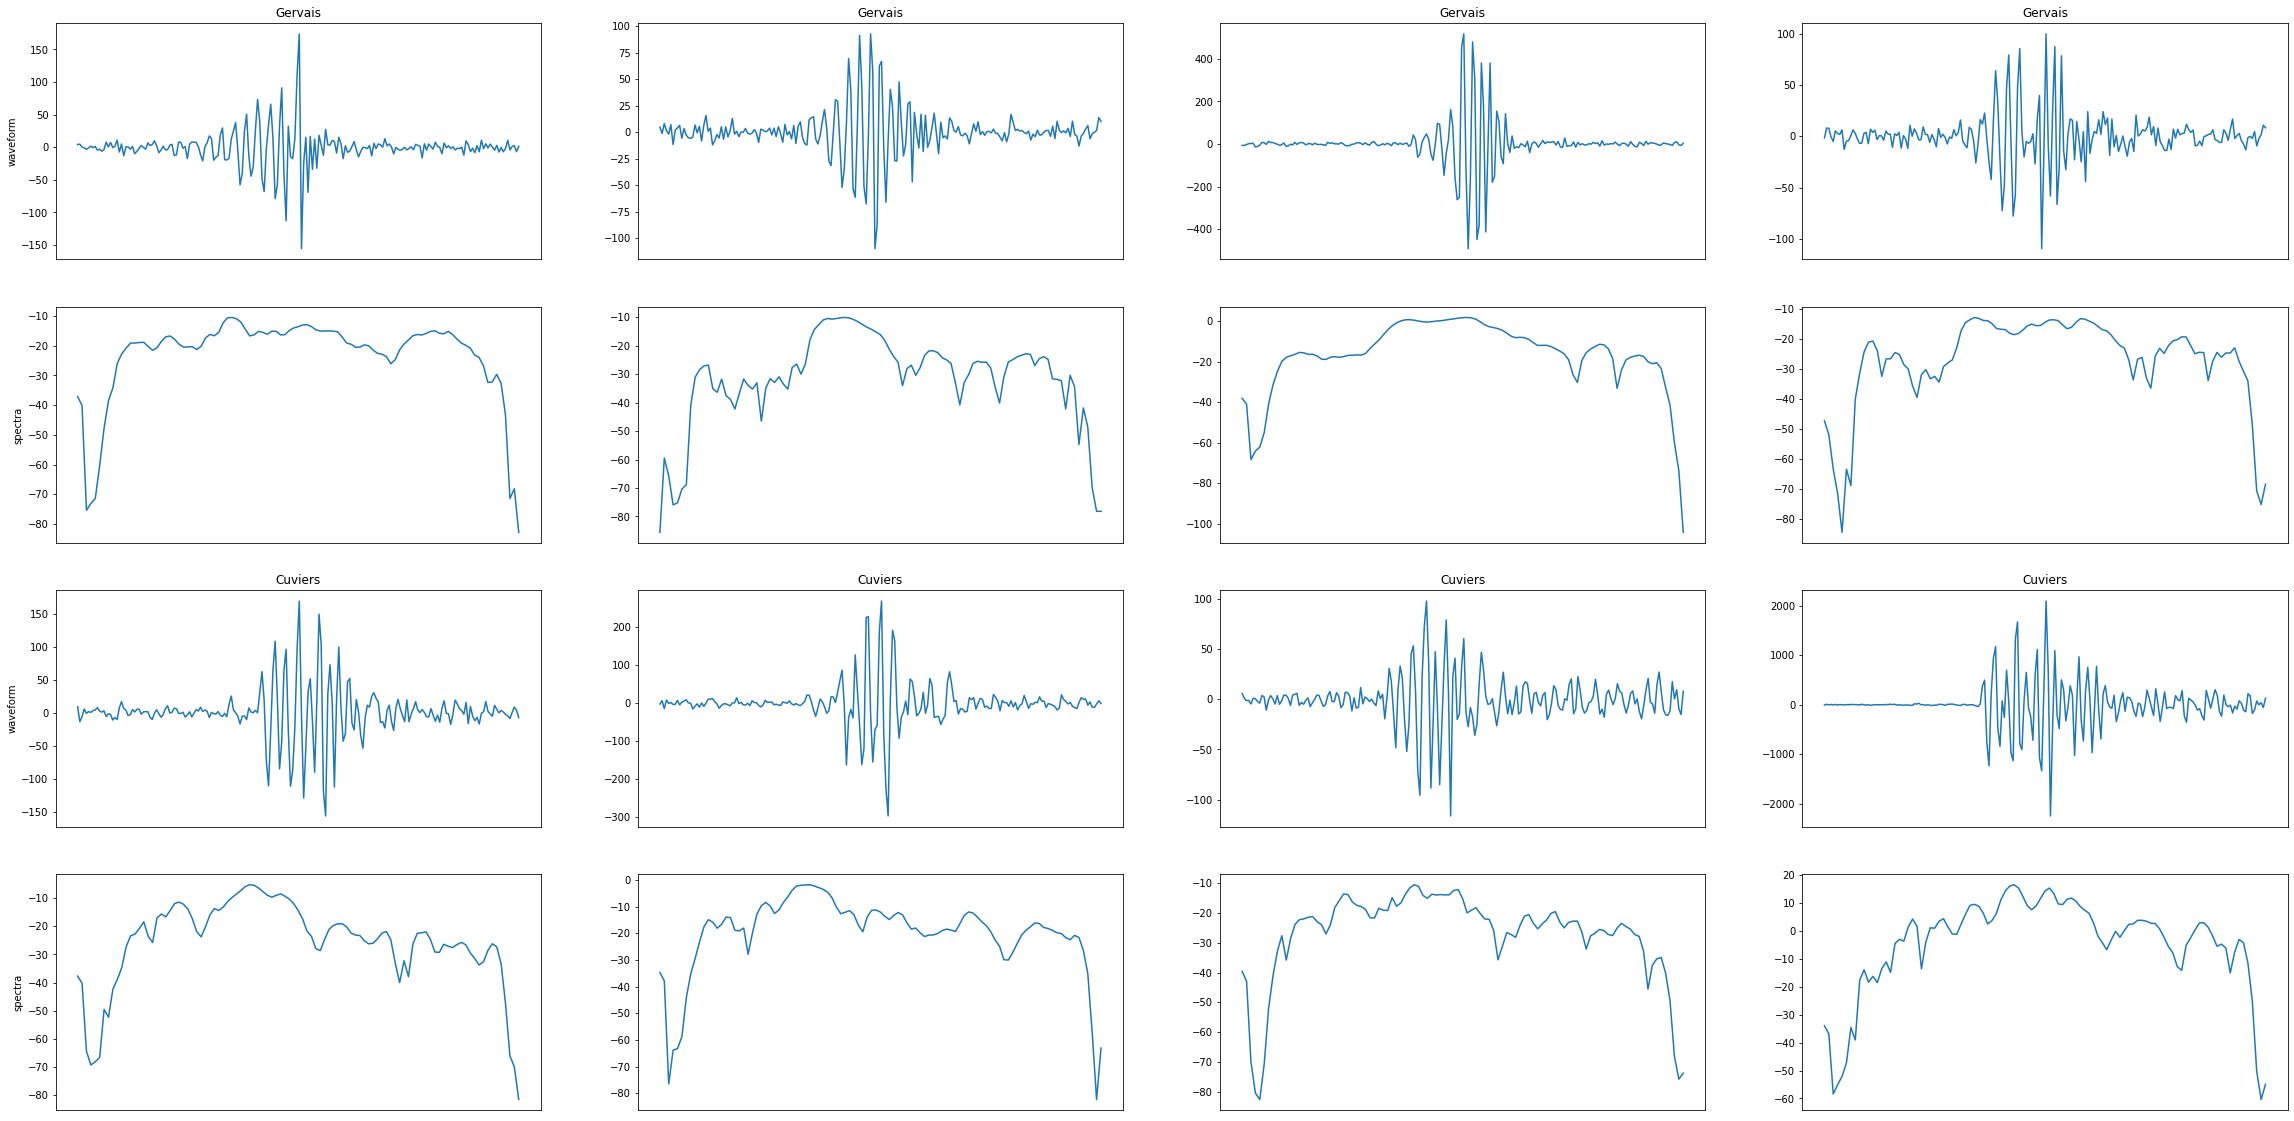

In [16]:
import numpy as np
import matplotlib.pyplot as plt

Gervais=df.filter(df.species=='Gervais').take(4)
Cuviers=df.filter(df.species=='Cuviers').take(4)
plt.figure(figsize=(40,20))
i=0

for row in Gervais+Cuviers: 
    waveform=np.frombuffer(row.MSN,np.float64)
    spectra= np.frombuffer(row.MSP,np.float64)
 
    plt.subplot(4,4,i+1)
    plt.plot(waveform)
    plt.title(row.species)
    plt.gca().axes.get_xaxis().set_ticks([])
    if(i %4)==0:
        plt.ylabel('waveform')
    plt.subplot(4,4,i+5)
    plt.plot(spectra)
    plt.gca().axes.get_xaxis().set_ticks([])
    if(i %4)==0:
        plt.ylabel('spectra')

    i+=1
    if i==4:
        i=8
   
    

In [26]:
def outerProduct(X):
    """Computer outer product and indicate which locations in matrix are undefined"""
    O=np.outer(X,X)
    N=1-np.isnan(O)
    return (O,N)

In [28]:
def sumWithNan(M1,M2):
    """Add two pairs of (matrix,count)"""
    
    (X1,N1)=M1
    (X2,N2)=M2
    N=N1+N2
    
    X=np.nansum(np.dstack((X1,X2)),axis=2)
   
    return (X,N)

In [46]:
def computeCov(RDDin):
    """computeCov recieves as input an RDD of np arrays, all of the same length, 
    and computes the covariance matrix for that set of vectors"""

    RDD=RDDin.map(lambda v:np.insert(v,0,1)) # insert a 1 at the beginning of each vector so that the same 
                                           #calculation also yields the mean vector

    OuterRDD=RDD.map(outerProduct)  # separating the map and the reduce does not matter because Spark uses lazy execution.
  
    (S,N)=OuterRDD.reduce(sumWithNan)
    # Unpack result and compute the covariance matrix
    # print 'RDD=',RDD.collect()
    # print 'shape of S=',S.shape,'shape of N=',N.shape
    # print 'S=',S
    # print 'N=',N
    E=S[0,1:]
    NE=np.float64(N[0,1:])
    # print('shape of E=',E.shape,'shape of NE=',NE.shape)
    Mean=E/NE
    O=S[1:,1:]
    NO=np.float64(N[1:,1:])
    Cov=O/NO - np.outer(Mean,Mean)
    # Output also the diagnal which is the variance for each day
    Var=np.array([Cov[i,i] for i in range(Cov.shape[0])])
    return {'E':E,'NE':NE,'O':O,'NO':NO,'Cov':Cov,'Mean':Mean,'Var':Var}

In [32]:
spectra= df.rdd.map(lambda row:np.frombuffer(row.MSP,np.float64))

COV=computeCov(spectra)

shape of E= (101,) shape of NE= (101,)


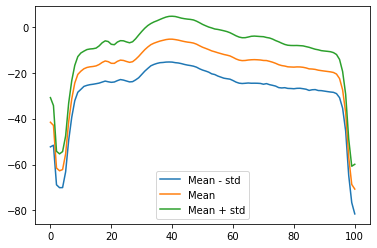

In [33]:
M=COV['Mean']
S=np.sqrt(COV['Var'])
plt.plot(M-S)
plt.plot(M)
plt.plot(M+S)
plt.legend(['Mean - std', 'Mean', 'Mean + std'])
plt.show()

shape of E= (101,) shape of NE= (101,)


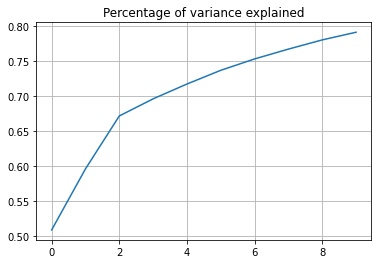

In [45]:
from numpy import linalg as LA
from numpy import shape

spectra=df.rdd.map(lambda row:np.frombuffer(row.MSP,np.float64))

## Extract Eigen Vectors
COV=computeCov(spectra)
eigval,eigvec=LA.eig(COV['Cov'])
eigval=eigval/sum(eigval)

## Check the Reconstruction
plt.plot(np.cumsum(eigval[:10])) # First 10 eigen vectors explains 80% of the overall variance
plt.grid()
plt.title("Percentage of variance explained");

In [64]:
## Using First 10 Eigen Vectors
V=eigvec[:,0:10]
## Defining a function to return Projection
def project(array):
    return np.dot(array, V)

In [65]:
def calc_stats(row):
    array = np.frombuffer(row.MSP,np.float64)
    projections = project(array)
    rmse = np.std(array)
    peak2peak = row.peak2peak
    label = 0 if row.species==u'Gervais' else 1
    return np.hstack((projections, [rmse, peak2peak, label]))

In [66]:
df_trimmed_data = df.rdd.map(calc_stats)

In [67]:
np_data = np.array(df_trimmed_data.collect())

In [111]:
np_data[3]

array([  7.36766715,   3.17945771, 115.77453793,  -5.08092628,
       -65.20127103,  13.90790587,  -3.53540208, -64.80321941,
         2.53570119,  42.72495781,  17.50523313,  72.7624    ,
         1.        ])

In [68]:
np_data.shape

(4175, 13)

In [69]:
X = np_data[:, :-1]
y = np.array(np_data[:, -1], dtype=int)

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [108]:
X_train[1]

array([180.46733297,   4.69923452,  90.25637252, -27.03034013,
       -85.38773501,  -7.46374182, -41.30321918, -65.52810288,
        21.77534006,  48.77299552,  15.18371097,  52.5731    ])

In [72]:
def xgboost_plst():
    param = {}
    param['max_depth']= 3   # depth of tree
    param['eta'] = 0.3      # shrinkage parameter
    param['silent'] = 1     # not silent
    param['objective'] = 'binary:logistic'
    param['nthread'] = 7 # Number of threads used
    param['eval_metric'] = 'logloss'

    plst = list(param.items())
    return plst

In [80]:
def stats_xgb(margin_scores):
  
    ms_mean = margin_scores.mean(axis=1)
    ms_std = margin_scores.std(axis=1)*3
    return  (ms_mean-ms_std).round(2),(ms_mean+ms_std).round(2)

#### XGBoost as classifier

In [91]:
import xgboost as xgb

def xgb_pred(X_train, X_test, y_train, y_test, n_bootstrap, minR, maxR, bootstrap_size, \
                   num_round=100, plst=xgboost_plst()):

    dtest = xgb.DMatrix(X_test,label=y_test)
    margin_scores = []
    n_bootstrap = 100
    n_samples = X_train.shape[0]
    lbound,hbound = int(n_bootstrap*minR),int(n_bootstrap*maxR)
    
    for i in range(n_bootstrap):
        # Sample boostrap_size indices from the training set with replacement
        random_idx = np.random.randint(0,n_samples,bootstrap_size)

        # Create train and test data matrices (dtrain, dtest) using xgb.DMatrix(X_sample, label=y_sample)
        X_sample,y_sample = X_train[random_idx],y_train[random_idx]
        dtrain = xgb.DMatrix(X_sample,label=y_sample)

        # Initialise the evallist parameter [(dtrain, 'train'), (dtest, 'eval')]
        evallist = [(dtrain, 'train'), (dtest, 'eval')]

        # Train the model using the XGBoost train API and make score predictions 
        model = xgb.train(params=plst,dtrain=dtrain,num_boost_round=num_round,evals=evallist,verbose_eval=False)
        pred = model.predict(dtest, ntree_limit=model.best_ntree_limit, output_margin=True)
        
        # Normalize them by dividing them with 
        # max(scores) - min(scores) and round these values to a precision of two decimal places
        scores = (pred/(max(pred)-min(pred))).round(2)

        margin_scores.append(scores)
    
    margin_scores = np.array(margin_scores).T
    
    margin_scores = np.sort(margin_scores, axis=1)
    
    # For each individual example, remove scores below the minRth percentile 
    # and greater than maxRth percentile (sort for each example if necessary)
    margin_scores = margin_scores[:,lbound:hbound]
    
    # Call the calc_stats function to compute min_scr and max_scr 
    # with the filtered margin scores as parameter
    min_scr, max_scr = stats_xgb(margin_scores)

    return min_scr, max_scr 
      

#### Calculating predictions

Based on the ranges for each of the examples, i.e, (min_scr, max_scr), we can predict whether it's a Gervais or a Cuvier. Since all our scores will be between -1 and +1, we use 0 as the margin line. All examples which are on the left side of the margin, can be classified as Cuvier's and all which are on the right side can be classified as Gervais. However, since we take margin scores from a set of bootstraps for each example, we use the minimum and maximum score arrays to predict to determine the classification.

The function predict takes the minimum score array and maximum score array and returns predictions as follows:

>If respective minimum score and maximum score values are less than 0, predict Cuvier

>If respective minimum score value is less than 0 and maximum score value is greater than 0, predict 0 (Unsure)

>If respective minimum score and maximum score values are greater than 0, predict Gervais

In [103]:
def predict(min_scr, max_scr):

    pred_min = np.where(min_scr <0, 'Cuvier', 'Gervais')
    pred_max = np.where(max_scr <0,  'Cuvier', 'Gervais')
    
    pred = np.where(pred_min == pred_max, pred_min, 0)
    
    return pred

In [101]:
def process(X_train, X_test, y_train, y_test, n_bootstrap=100):
    min_scr, max_scr = xgb_pred(X_train, X_test, y_train, y_test, n_bootstrap=n_bootstrap, minR=0.1, maxR=0.9, bootstrap_size=len(X_train))
    pred = predict(min_scr, max_scr)
    return min_scr, max_scr, pred

In [104]:
min_scr, max_scr, pred = process(X_train, X_test, y_train, y_test)

In [105]:
pred

array(['Gervais', 'Gervais', 'Gervais', 'Gervais', 'Gervais', '0', '0',
       'Cuvier', '0', 'Gervais', 'Cuvier', 'Cuvier', 'Gervais', '0', '0',
       '0', 'Cuvier', '0', '0', 'Cuvier', 'Cuvier', 'Gervais', 'Cuvier',
       'Gervais', 'Gervais', 'Cuvier', 'Cuvier', '0', 'Gervais', 'Cuvier',
       'Cuvier', 'Gervais', 'Cuvier', 'Gervais', 'Gervais', 'Cuvier',
       'Cuvier', 'Gervais', '0', '0', '0', 'Cuvier', 'Gervais', '0',
       'Cuvier', 'Gervais', 'Gervais', '0', 'Gervais', 'Gervais',
       'Gervais', 'Gervais', 'Gervais', 'Gervais', 'Gervais', 'Gervais',
       'Gervais', 'Gervais', 'Cuvier', 'Cuvier', 'Gervais', 'Cuvier', '0',
       'Gervais', '0', 'Cuvier', 'Gervais', 'Gervais', '0', 'Gervais',
       'Gervais', 'Cuvier', 'Gervais', 'Gervais', 'Gervais', 'Gervais',
       'Cuvier', 'Gervais', '0', 'Gervais', '0', 'Gervais', 'Gervais',
       'Cuvier', '0', '0', 'Gervais', '0', '0', 'Gervais', '0', 'Gervais',
       'Gervais', 'Gervais', '0', 'Gervais', 'Gervais', 'Gervais